In [85]:
import mlp.layers as layers
import mlp.initialisers as init
class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
        self.output_dim_1=output_dim_1
        self.output_dim_2=output_dim_2
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
             num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        batch_size=inputs.shape[0]
        self.batch_size=batch_size
        batch_size,num_input_channels,input_dim_1, input_dim_2=inputs.shape
        grads_wrt_inputs=np.zeros((batch_size,num_input_channels,input_dim_1, input_dim_2))
        num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2=self.kernels_shape
        outputs=np.zeros((self.batch_size,self.num_output_channels,self.output_dim_1, self.output_dim_2))
        aaa=self.kernels_shape
        for batch in range(batch_size):
            inputs3d=inputs[batch,:,:,:]
            outputs3d=outputs[batch,:,:,:]
            for k in range(num_output_channels):
                k_3d=self.kernels[k,:,:,:]
                conv_2d=np.zeros((self.output_dim_1,self.output_dim_2))
                for i in range(num_input_channels):
                    inputs_2d=inputs3d[i,:,:]
                    kernel_2d=k_3d[i,:,:]
                    conv_2d += signal.convolve2d(inputs_2d,kernel_2d,'valid')
                outputs3d[k,:,:]=conv_2d+self.biases[k]
            outputs[batch,:,:,:]=outputs3d
        return outputs
            
    

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
        """
        S=1
        P=0
        batch_size,num_input_channels,input_dim_1, input_dim_2=inputs.shape
        batch_size, num_output_channels, output_dim_1, output_dim_2=outputs.shape
        batch_size, num_output_channels, output_dim_1, output_dim_2=grads_wrt_outputs.shape
        grads_wrt_inputs=np.zeros((batch_size,num_input_channels,input_dim_1, input_dim_2))
        num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2=self.kernels_shape
        for i in range(batch_size):
            grads_wrt_inputs_3d=grads_wrt_inputs[i,:,:,:]
            grads_wrt_outputs_3d=grads_wrt_outputs[i,:,:,:]
            
            for j in range(num_input_channels):
                kernels_3d=self.kernels[:,j,:,:]
                conv_2d=np.zeros((input_dim_1, input_dim_2))
                
                for k in range(num_output_channels):
                    grads_wrt_outputs_2d=grads_wrt_outputs_3d[k,:,:]
                    kernels_2d=kernels_3d[k,:,:]
                    
                    kernels_2d_rotate=np.rot90(kernels_2d,2)
                    conv_2d += signal.convolve2d(kernels_2d_rotate,grads_wrt_outputs_2d,'full')
                grads_wrt_inputs_3d[j,:,:]=conv_2d
            grads_wrt_inputs[i,:,:,:]=grads_wrt_inputs_3d
                
                
        return grads_wrt_inputs

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        """
        
        ####this method is slightly different from the previous 2 for reducing the dimension, in this methold we 
        #could take care of stride and pad.
#         batch_size,num_input_channels,input_dim_1, input_dim_2=inputs.shape
#         batch_size, num_output_channels, output_dim_1, output_dim_2=grads_wrt_outputs.shape
#         num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2=self.kernels_shape
#         s=1
#         pad=0
#         grads_wrt_kernels = np.zeros((num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2))
#         grad_wrt_biases = np.zeros((num_output_channels))
#         for i in range(batch_size):
#             for j in range (num_output_channels):
#                 for k in range(self.output_dim_1):
#                     for l in range(self.output_dim_2):
#                         grad_wrt_biases[j] += grads_wrt_outputs[i, j, k, l]
#                         www=inputs[i,:,k:k+kernel_dim_1,l:l+kernel_dim_2]
#                         grads_wrt_kernels[j]+=www*grads_wrt_outputs[i,j,k,l]
#"try failed",
        batch_size,num_input_channels,input_dim_1, input_dim_2=inputs.shape
        num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2=self.kernels_shape
        grads_wrt_biases=np.zeros((num_output_channels))
        grads_wrt_kernels=np.zeros((num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2))
        for i in range(num_output_channels):
            grads_wrt_outputs_3d=grads_wrt_outputs[:,i,:,:]
            dw3d=grads_wrt_kernels[i,:,:,:]
            for j in range(num_input_channels):
                conv2d=np.zeros((kernel_dim_1,kernel_dim_2))
                inputs3d=inputs[:,j,:,:]
                for k in range(num_output_channels):
                    grads_wrt_outputs_2d=grads_wrt_outputs_3d[k,:,:]
                    inputs2d=inputs3d[k,:,:]                    
                    inputs2d=np.rot90(inputs2d,2)
                    conv2d +=signal.convolve2d( inputs2d, grads_wrt_outputs_2d,'valid')
                    
                    grads_wrt_biases[i]=np.sum(grads_wrt_outputs[:,i,:,:])
                dw3d[j,:,:]=conv2d
            grads_wrt_kernels[i,:,:,:]=dw3d
        return grads_wrt_kernels,grads_wrt_biases

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
from numpy import rot90
import mlp.initialisers as init
from mlp.layers import ReshapeLayer,MaxPoolingLayer,ReluLayer
from scipy import signal
import numpy as np
from numpy import rot90
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim,hidden_dim = 784, 10 ,100

In [87]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

Epoch 0:
  error(train)=2.34e+00, acc(train)=9.01e-02, error(valid)=2.34e+00, acc(valid)=9.15e-02, params_penalty=0.00e+00
Epoch 5: 285.26s to complete
  error(train)=2.31e+00, acc(train)=9.98e-02, error(valid)=2.31e+00, acc(valid)=9.61e-02, params_penalty=0.00e+00
Epoch 10: 260.89s to complete
  error(train)=2.31e+00, acc(train)=1.02e-01, error(valid)=2.31e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 15: 196.84s to complete
  error(train)=2.31e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 20: 196.67s to complete
  error(train)=2.31e+00, acc(train)=1.14e-01, error(valid)=2.31e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 25: 196.80s to complete
  error(train)=2.30e+00, acc(train)=1.14e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 30: 196.96s to complete
  error(train)=2.31e+00, acc(train)=9.72e-02, error(valid)=2.31e+00, acc(valid)=9.83e-02, params_penalty=0.00e+00
Epoch 35: 196.

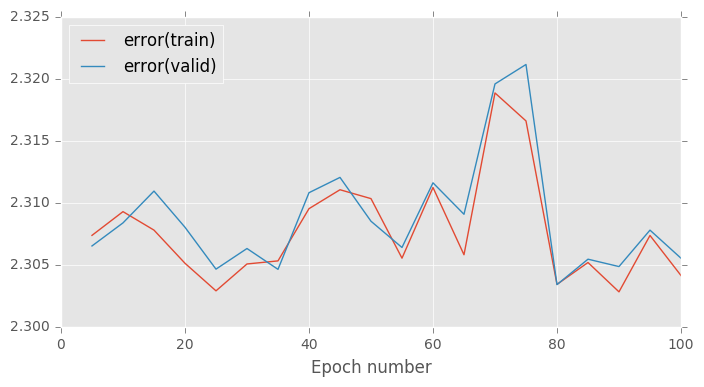

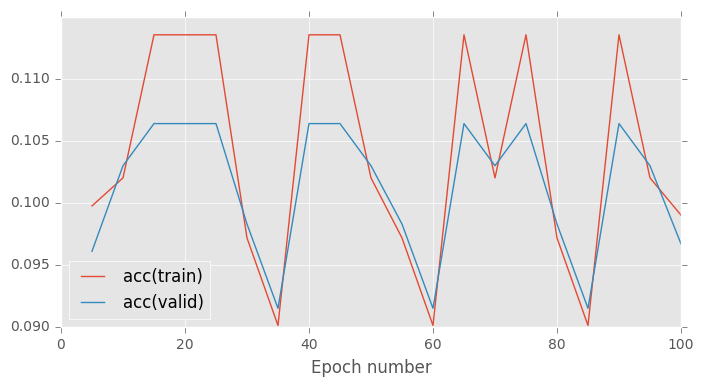

In [83]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)
### creat parameters for ConvLayer
num_input_channels=1
num_output_channels=3
input_dim_1=28
input_dim_2=28
kernel_dim_1=5
kernel_dim_2=5
# Create affine + softmax model
model = MultipleLayerModel([
    ReshapeLayer((1,28,28)),
    ConvolutionalLayer(1,3,28,28,5,5),
    ReluLayer(),
    ReshapeLayer((3*24*24,)),
    MaxPoolingLayer(4),
    ReshapeLayer((3,12,12,)),
    ConvolutionalLayer(3,6,12,12,5,5),
    ReluLayer(),
    ReshapeLayer((6*8*8,)),
    MaxPoolingLayer(4),
    SigmoidLayer(),
    AffineLayer(96,10),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

Epoch 0:
  error(train)=2.43e+00, acc(train)=9.01e-02, error(valid)=2.43e+00, acc(valid)=9.15e-02, params_penalty=0.00e+00
Epoch 5: 134.00s to complete
  error(train)=4.59e-01, acc(train)=8.72e-01, error(valid)=4.05e-01, acc(valid)=8.95e-01, params_penalty=0.00e+00
Epoch 10: 134.09s to complete
  error(train)=3.73e-01, acc(train)=8.91e-01, error(valid)=3.28e-01, acc(valid)=9.09e-01, params_penalty=0.00e+00
Epoch 15: 134.05s to complete
  error(train)=3.40e-01, acc(train)=8.99e-01, error(valid)=3.01e-01, acc(valid)=9.16e-01, params_penalty=0.00e+00
Epoch 20: 133.98s to complete
  error(train)=3.19e-01, acc(train)=9.05e-01, error(valid)=2.83e-01, acc(valid)=9.21e-01, params_penalty=0.00e+00
Epoch 25: 133.96s to complete
  error(train)=3.10e-01, acc(train)=9.06e-01, error(valid)=2.76e-01, acc(valid)=9.21e-01, params_penalty=0.00e+00
Epoch 30: 133.79s to complete
  error(train)=3.02e-01, acc(train)=9.10e-01, error(valid)=2.70e-01, acc(valid)=9.25e-01, params_penalty=0.00e+00
Epoch 35: 133.

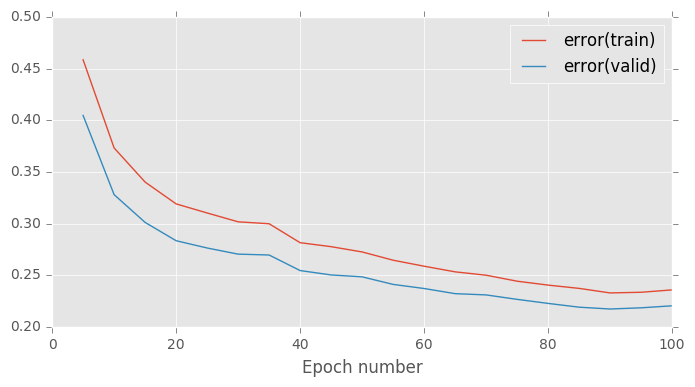

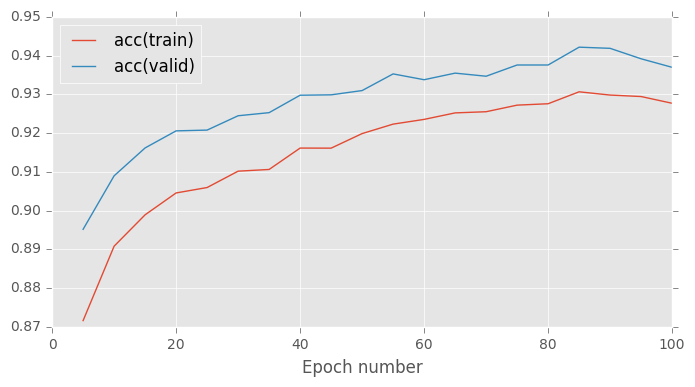

In [84]:
#Simple CNN Layer with one full connected layer

# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    ReshapeLayer((1,28,28)),
    ConvolutionalLayer(1,3,28,28,5,5),
    ReluLayer(),
    ReshapeLayer((3*24*24,)),
    MaxPoolingLayer(4),
    SigmoidLayer(),
    AffineLayer(432,10),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

In [ ]:
## Simple CNN Layer with one full connected layer

# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    ReshapeLayer((1,28,28)),
    ConvolutionalLayer(1,3,28,28,5,5),
    ReluLayer(),
    ReshapeLayer((3*24*24,)),
    MaxPoolingLayer(4),
    ReluLayer(),
    SigmoidLayer(),
    AffineLayer(432,100),
    ReluLayer(),
    AffineLayer(100,10),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

Epoch 0:
  error(train)=2.31e+00, acc(train)=9.86e-02, error(valid)=2.31e+00, acc(valid)=9.91e-02, params_penalty=0.00e+00
